# Question: Which runtime produced the highest IMDb ratings?
We would like to see how IMDb ratings are distributed with respect to runtime.

## Loading data
Below we import our database and print the column names for the `ratings` and `runtimes` tables. We will join these tables to form our data set. 

In [11]:
from moviesdb import moviesdb as mdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
db = mdb.MoviesDb()

In [13]:
print('=== runtimes ===')
for column in db.list_column_names('runtimes'):
    print(column)

print('')
print('=== ratings ===')
for column in db.list_column_names('ratings'):
    print(column)

=== runtimes ===
tconst
runtime_minutes

=== ratings ===
tconst
averagerating
numvotes


We can join the `runtimes` and `ratings` tables on the `tconst` variable. this will produce a dataset with all films for which we have both rating and runtime data. 

In [14]:
query = """
SELECT ru.runtime_minutes, ra.averagerating, ra.numvotes
FROM runtimes as ru
INNER JOIN ratings AS ra
USING('tconst')
"""
df = db.load_query_as_df(query)

## Question specific data cleaning
There are a few films with extremely long run times, we focus our analysis on films with run times shorter than four hours.   

In [15]:
df = df.query('runtime_minutes <= 240')

## Computations
To ensure that each vote counts equally toward the aggregated mean rating, we compute the vote weighted mean of ratings for each runtime in our data set. 

In [21]:
df['vote_weighted_rating'] = df['averagerating']*df['numvotes']
df_agg = df.groupby(by='runtime_minutes').agg('sum').reset_index()
df_out = pd.DataFrame()
df_out['runtime_minutes'] = df_agg['runtime_minutes']
df_out['mean_rating'] = df_agg['vote_weighted_rating'] / df_agg['numvotes']

We smooth the data by taking a rolling average of ratings with a window size of ten minutes.

In [22]:
df_smoothed = df_out.rolling(on= 'runtime_minutes', window=10).sum()

## Data Visualization
Below we plot the distribution of number of votes with respect to runtime.

<Figure size 576x396 with 0 Axes>

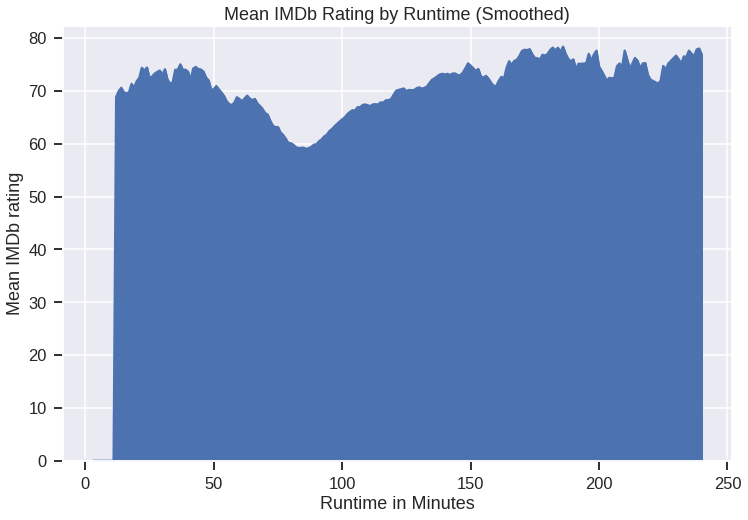

In [23]:
plt.figure()
plt.style.use('seaborn')
sns.set_context('talk')
df_smoothed.plot.area(x='runtime_minutes', 
                      y='mean_rating', 
                      figsize=(12,8),
                      xlabel = 'Runtime in Minutes', 
                      ylabel = 'Mean IMDb rating', 
                      title = 'Mean IMDb Rating by Runtime (Smoothed)',
                      legend = None,
                
                     )
plt.savefig('../images/rating_by_runtime.png', bbox_inches='tight')

## Conclusion
We see that mean IMDb rating is minimized at a runtime of 86 minutes. One might speculate movies with a large number of votes might have lower ratings, however we have seen that the number of votes peaks near the 109 minute mark, so the dip in ratings around the 86 minute runtime is not so easily explained away.

In [25]:
argmin = df_smoothed.loc[df_smoothed['mean_rating'].idxmin(),'runtime_minutes']
print(f'The mean IMDb rating is minimized at a runtime of {argmin} minutes.')

The mean IMDb rating is minimized at a runtime of 86 minutes.
